### Replication of Original INLP

In [18]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import debias
#import debias_old as debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000
from sklearn.utils import shuffle

#import warnings
#warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14512\3807002410.py:27: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2"):

  tsne = TSNE(n_components=2)#, angle = 0.5, perplexity = 20)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  names = sorted(set(labels.tolist()))

  plt.figure(figsize=(6, 5))
  colors = "red", "blue"
  for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
     plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label if ind2label is None else ind2label[label], alpha = 0.3, marker = "s" if i==0 else "o")
     plt.legend(loc = "upper right")

  plt.title(title)
  plt.savefig("embeddings.{}.png".format(title), dpi=600)
  plt.show()
  return vecs_2d

In [20]:
def tsne(vecs, labels, title="", ind2label=None, words=None, metric="l2", manual_direction=None, emphasize_factor=1.0):
    """
    Apply t-SNE dimensionality reduction with emphasis on the grammatical gender direction.
    
    :param vecs: List of vectors to reduce.
    :param labels: Labels corresponding to the vectors.
    :param title: Title for the plot.
    :param ind2label: Dictionary mapping label indices to label names (optional).
    :param words: List of words corresponding to the vectors (optional).
    :param metric: Metric to use for distance calculation (default: "l2").
    :param manual_direction: A vector representing a direction to emphasize (optional).
    :param emphasize_factor: Scaling factor for emphasizing the manual direction.
    :return: The 2D representations of the vectors.
    """
    vecs = np.array(vecs)
    labels = np.array(labels)

    # Emphasize manual direction
    if manual_direction is not None:
        manual_direction = np.array(manual_direction)
        manual_direction = manual_direction / np.linalg.norm(manual_direction)  # Normalize
        projection = np.dot(vecs, manual_direction)[:, np.newaxis]  # Project onto manual direction
        vecs = np.hstack((vecs, emphasize_factor * projection))  # Add as an additional feature

    # Apply t-SNE
    tsne = TSNE(n_components=2, metric=metric)
    vecs_2d = tsne.fit_transform(vecs)

    # Plot the results
    label_names = sorted(list(set(labels.tolist())))
    names = sorted(set(labels.tolist()))

    plt.figure(figsize=(6, 5))
    colors = ["red", "blue"]  # Adjust as needed for more labels
    for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
        plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                    label=label if ind2label is None else ind2label[label], alpha=0.3, 
                    marker="s" if i == 0 else "o")
    plt.legend(loc="upper right")
    plt.title(title)
    #plt.savefig(f"embeddings.{title}.png", dpi=600)
    plt.show()

    return vecs_2d

### Data loading & processing

In [21]:
def load_word_vectors(fname):
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = model.index_to_key  # Replace `model.vocab.keys()` with `model.index_to_key`
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors, n = 2500):
    
    group1 = model.similar_by_vector(gender_vector, topn = n, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = n, restrict_vocab=None)
    
    all_sims = model.similar_by_vector(gender_vector, topn = len(model.vectors), restrict_vocab=None)
    eps = 0.03
    idx = [i for i in range(len(all_sims)) if abs(all_sims[i][1]) < eps]
    samp = set(np.random.choice(idx, size = n))
    neut = [s for i,s in enumerate(all_sims) if i in samp]
    return group1, group2, neut

def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    
    vecs = []
    for w in word_list:

        if w not in model:
            continue
            
        vecs.append(model[w])
    
    vecs = np.array(vecs)

    return vecs
    
def get_bias_by_neighbors(model, v, gender_direction, topn): 
    
    neighbors = model.similar_by_vector(v, topn = topn) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    bias /= (1.*topn)
    return bias


def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm_notebook(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

### Load word vectors

In [7]:
# English embeddings

model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt")

In [6]:
# Spanish embeddings

model_esp = KeyedVectors.load('../data/embeddings/keyedvectors/model_esp.kv', mmap='r')

In [22]:
FR_model = KeyedVectors.load('../data/embeddings/keyedvectors/model_fr.kv', mmap='r')

### Collect biased words

In [8]:
# English

num_vectors_per_class = 7500

by_pca = False
if by_pca:
    pairs = [("male", "female"), ("masculine", "feminine"), ("he", "she"), ("him", "her")]
    gender_vecs = [model[p[0]] - model[p[1]] for p in pairs]
    pca = PCA(n_components=1)
    pca.fit(gender_vecs)
    gender_direction = pca.components_[0]
    
else:
    gender_direction = model["he"]-model["she"] 


gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
masc_words_and_scores, fem_words_and_scores, neut_words_and_scores = project_on_gender_subspaces(gender_direction, model, n = num_vectors_per_class)

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))
masc_vecs, fem_vecs = get_vectors(masc_words, model), get_vectors(fem_words, model)
neut_vecs = get_vectors(neut_words, model)

n = min(3000, num_vectors_per_class)
all_significantly_biased_words = masc_words[:n] + fem_words[:n]
all_significantly_biased_vecs =  np.concatenate((masc_vecs[:n], fem_vecs[:n]))
all_significantly_biased_labels = np.concatenate((np.ones(n, dtype = int),
                                                  np.zeros(n, dtype = int)))

all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)
#print(np.random.choice(masc_words, size = 75))
print("TOP MASC")
print(masc_words[:50])
#print("LAST MASC")
#print(masc_words[-120:])
print("-------------------------")
#print(np.random.choice(fem_words, size = 75))
print("TOP FEM")
print(fem_words[:50])
#print("LAST FEM")
#print(fem_words[-120:])
print("-------------------------")
#print(np.random.choice(neut_words, size = 75))
print(neut_words[:50])


TOP MASC
('drafted', 'qb', 'soriano', 'himself', 'cardinals', 'giants', 'he', 'bullpen', 'sabean', 'jagr', 'muhammad', 'alou', 'rangers', 'defensive', 'draft', 'belichick', 'rookie', 'ratzinger', 'obp', 'santonio', 'muhammed', 'yankees', 'outfielder', 'preached', 'playmaker', 'lineman', 'offensive', 'wr', 'steelers', 'redskins', 'rushers', 'his', 'punter', 'anquan', 'boldin', 'bochy', 'caesarea', 'nfl', 'umenyiora', 'laurinaitis', 'flacco', 'rc', 'eusebius', 'packers', 'lhp', 'homers', 'mitre', 'linebacker', 'rhp', 'manny')
-------------------------
TOP FEM
('nichole', 'ftv', 'renee', 'sophie', 'christina', 'marie', 'pregnant', 'nicole', 'samantha', 'denise', 'sassy', 'madeline', 'alicia', 'lynette', 'xoxo', 'melanie', 'michelle', 'missy', 'kimberly', 'melissa', 'kayla', 'angelina', 'kristin', 'jennifer', 'emma', 'katie', 'pregnancy', 'jessica', 'heidi', 'tina', 'mandy', 'erika', 'maggie', 'shes', 'elaine', 'julie', 'vanessa', 'actress', 'leanne', 'kristina', 'faye', 'alexandra', 'tany

In [7]:
# Spansih

# Biased words according to INLP
num_vectors_per_class = 7500

gender_direction = model_esp["él"]-model_esp["ella"] 


gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
masc_words_and_scores, fem_words_and_scores, neut_words_and_scores = project_on_gender_subspaces(gender_direction, model_esp, n = num_vectors_per_class)

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))
masc_vecs, fem_vecs = get_vectors(masc_words, model_esp), get_vectors(fem_words, model_esp)
neut_vecs = get_vectors(neut_words, model_esp)

n = min(3000, num_vectors_per_class)
all_significantly_biased_words = masc_words[:n] + fem_words[:n]
all_significantly_biased_vecs =  np.concatenate((masc_vecs[:n], fem_vecs[:n]))
all_significantly_biased_labels = np.concatenate((np.ones(n, dtype = int),
                                                  np.zeros(n, dtype = int)))

all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)
#print(np.random.choice(masc_words, size = 75))
print("TOP MASC")
print(masc_words[:50])
#print("LAST MASC")
#print(masc_words[-120:])
print("-------------------------")
#print(np.random.choice(fem_words, size = 75))
print("TOP FEM")
print(fem_words[:50])
#print("LAST FEM")
#print(fem_words[-120:])
print("-------------------------")
#print(np.random.choice(neut_words, size = 75))
print(neut_words[:50])


TOP MASC
('legendario', 'veterano', 'seguidor', 'apodado', 'mesías', 'discípulo', 'mismísimo', 'visionario', 'hacedor', 'excelso', 'adversario', 'habilidoso', 'reputado', 'creador', 'sucesor', 'lugartenientes', 'acérrimo', 'reverenciado', 'glorificado', 'sanedrín', 'tiberius', 'mítico', 'honrado', 'fanático', 'todopoderoso', 'astuto', 'impostor', 'diógenes', 'ungido', 'famoso', 'pensador', 'comandado', 'erudito', 'rabí', 'sabio', 'siervo', 'héroe', 'incrédulo', 'renegado', 'teófilo', 'venerado', 'mesiánico', 'piadoso', 'discípulos', 'sanguinario', 'moisés', 'reformador', 'comandados', 'intrépido', 'perseguidor')
-------------------------
TOP FEM
('niña', 'bibliotecaria', 'consentida', 'ella', 'amiga', 'cuidadora', 'mia', 'tia', 'empresaria', 'cantautora', 'buenorra', 'escritora', 'actriz', 'anciana', 'trabajadora', 'lesbiana', 'chica', 'mama', 'fiestera', 'drogadicta', 'profesora', 'tumbada', 'compositora', 'granjera', 'seductora', 'fumadora', 'patinadora', 'drogada', 'embarazada', 'ob

In [23]:
# French

# Biased words according to INLP
num_vectors_per_class = 7500

gender_direction = FR_model["il"]-FR_model["elle"] 


gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
masc_words_and_scores, fem_words_and_scores, neut_words_and_scores = project_on_gender_subspaces(gender_direction, FR_model, n = num_vectors_per_class)

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))
masc_vecs, fem_vecs = get_vectors(masc_words, FR_model), get_vectors(fem_words, FR_model)
neut_vecs = get_vectors(neut_words, FR_model)

n = min(3000, num_vectors_per_class)
all_significantly_biased_words = masc_words[:n] + fem_words[:n]
all_significantly_biased_vecs =  np.concatenate((masc_vecs[:n], fem_vecs[:n]))
all_significantly_biased_labels = np.concatenate((np.ones(n, dtype = int),
                                                  np.zeros(n, dtype = int)))

all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels = sklearn.utils.shuffle(
all_significantly_biased_words, all_significantly_biased_vecs, all_significantly_biased_labels)
#print(np.random.choice(masc_words, size = 75))
print("TOP MASC")
print(masc_words[:50])
#print("LAST MASC")
#print(masc_words[-120:])
print("-------------------------")
#print(np.random.choice(fem_words, size = 75))
print("TOP FEM")
print(fem_words[:50])
#print("LAST FEM")
#print(fem_words[-120:])
print("-------------------------")
#print(np.random.choice(neut_words, size = 75))
print(neut_words[:50])

TOP MASC
('il', 'Il', 'y', 'iI', 'qu', 'a', 'on', "S'", ',', "s'", "n'", 'ya', 'iol', 'où', 'IL', '1.Il', "y'", 'On', 'ça', 'ce', ',il', 'Iil', 'Là', ".S'", '1-Il', '8.Il', 'ne', 'si', 'ça.Il', 'a.Il', 'Ce', '7Il', 'iIl', "c'", '1Il', 'Ça', '.Il', '9Il', "qi'", 'vu.Il', 'çà', '60Il', 'là', 'iil', '2.Il', "qui'", '24Il', '4.Il', '7.Il', 'va.Il')
-------------------------
TOP FEM
('Andreanne', 'lachaîne', '.Mini', 'Audrey-Laure', 'organi-sation', 'Scandibérique', 'Nathanaelle', 'féminine-', 'Bertie-Albrecht', 'extérieureArts', 'Laurentais', 'Tenancière', '1964-1989Bulletin', 'urbainDéveloppement', 'rollerenligne.com', 'payeuse', 'Stever', 'Anne-Céline', 'Interlocutrice', 'Caractérielle', 'Maarten.svg', 'minitieuse', 'activitéFaire', 'monier', 'Guyons', 'Serga', 'André-Laurent', 'Paralympics.svg', 'Samuelle', 'Joseline', 'conscrite', 'Opérative', 'jourée', 'enfants.JPG', 'Sénépart', 'Cavalon', 'Alysée', 'Facilitatrice', 'résultatsPage', 'Karolin', 'Guénolée', 'Claricia', 'hall.JPG', 'rica

### Perform train-dev-test split

In [10]:
# English

random.seed(0)
np.random.seed(0)

X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis = 0)
#X = (X - np.mean(X, axis = 0, keepdims = True)) / np.std(X, axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype = int)
y_fem = np.zeros(fem_vecs.shape[0], dtype = int)
y_neut = -np.ones(neut_vecs.shape[0], dtype = int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem, y_neut))
X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 10766; Dev size: 4615; Test size: 6592


In [8]:
# Spanish

random.seed(0)
np.random.seed(0)

X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis = 0)
#X = (X - np.mean(X, axis = 0, keepdims = True)) / np.std(X, axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype = int)
y_fem = np.zeros(fem_vecs.shape[0], dtype = int)
y_neut = -np.ones(neut_vecs.shape[0], dtype = int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem, y_neut))
X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 10683; Dev size: 4579; Test size: 6542


In [24]:
# French

random.seed(0)
np.random.seed(0)

X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis = 0)
#X = (X - np.mean(X, axis = 0, keepdims = True)) / np.std(X, axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype = int)
y_fem = np.zeros(fem_vecs.shape[0], dtype = int)
y_neut = -np.ones(neut_vecs.shape[0], dtype = int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem, y_neut))
X_train_dev, X_test, y_train_dev, Y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 11004; Dev size: 4717; Test size: 6738


### Debias

In [12]:
# English

gender_clf = LinearSVC
#gender_clf = SGDClassifier
#gender_clf = LogisticRegression
#gender_clf = LinearDiscriminantAnalysis
#gender_clf = Perceptron

params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc
#params = {'loss': 'hinge', 'n_jobs': 16, 'penalty': 'l2', 'max_iter': 2500, 'random_state': 0}
#params = {}
n = 35
min_acc = 0
is_autoregressive = True
dropout_rate = 0

P, rowspace_projs, Ws, accuracies = debias.get_debiasing_projection(gender_clf, params, n, 300, is_autoregressive, min_acc,
                                    X_train, Y_train, X_dev, Y_dev,
                                       Y_train_main=None, Y_dev_main=None, 
                                        by_class = False, dropout_rate = dropout_rate)

iteration: 0, accuracy: 0.9588299024918743:   3%|█▏                                         | 1/35 [00:01<00:39,  1.15s/it]

iteration: 1, accuracy: 0.7014084507042253:   6%|██▍                                        | 2/35 [00:02<00:49,  1.49s/it]

iteration: 2, accuracy: 0.5971830985915493:   9%|███▋                                       | 3/35 [00:04<00:50,  1.56s/it]

iteration: 3, accuracy: 0.5152762730227519:  11%|████▉                                      | 4/35 [00:06<00:49,  1.60s/it]

iteration: 4, accuracy: 0.4611050920910076:  14%|██████▏                                    | 5/35 [00:07<00:47,  1.59s/it]

iteration: 5, accuracy: 0.4279523293607801:  17%|███████▎                                   | 6/35 [00:09<00:46,  1.59s/it]

iteration: 6, accuracy: 0.38613217768147345:  20%|████████▍                                 | 7/35 [00:10<00:41,  1.47s/it]

iteration: 7, accuracy: 0.371397616468039:  23%|██████████                                  | 8/35 [00:11<00:38,  1.43s/it]

iteration: 8, accuracy: 0.3514626218851571:  26%|███████████                                | 9/35 [00:13<00:35,  1.38s/it]

iteration: 9, accuracy: 0.3460455037919827:  29%|████████████                              | 10/35 [00:14<00:35,  1.42s/it]

iteration: 10, accuracy: 0.3674972914409534:  29%|███████████▋                             | 10/35 [00:16<00:35,  1.42s/it]

iteration: 11, accuracy: 0.36511375947995667:  34%|█████████████▋                          | 12/35 [00:18<00:35,  1.56s/it]

iteration: 12, accuracy: 0.3609967497291441:  37%|███████████████▏                         | 13/35 [00:19<00:35,  1.63s/it]

iteration: 13, accuracy: 0.3384615384615385:  40%|████████████████▍                        | 14/35 [00:21<00:32,  1.55s/it]

iteration: 14, accuracy: 0.3284940411700975:  43%|█████████████████▌                       | 15/35 [00:22<00:30,  1.52s/it]

iteration: 15, accuracy: 0.3293607800650054:  46%|██████████████████▋                      | 16/35 [00:24<00:28,  1.52s/it]

iteration: 16, accuracy: 0.3358613217768147:  49%|███████████████████▉                     | 17/35 [00:25<00:27,  1.52s/it]

iteration: 17, accuracy: 0.3378114842903575:  51%|█████████████████████                    | 18/35 [00:27<00:24,  1.45s/it]

iteration: 18, accuracy: 0.3492957746478873:  54%|██████████████████████▎                  | 19/35 [00:28<00:21,  1.35s/it]

iteration: 19, accuracy: 0.3354279523293608:  57%|███████████████████████▍                 | 20/35 [00:29<00:18,  1.25s/it]

iteration: 20, accuracy: 0.3367280606717226:  60%|████████████████████████▌                | 21/35 [00:30<00:16,  1.18s/it]

iteration: 21, accuracy: 0.3302275189599133:  63%|█████████████████████████▊               | 22/35 [00:31<00:14,  1.12s/it]

iteration: 22, accuracy: 0.3328277356446371:  63%|█████████████████████████▊               | 22/35 [00:31<00:14,  1.12s/it]

iteration: 23, accuracy: 0.3317443120260022:  66%|██████████████████████████▉              | 23/35 [00:33<00:12,  1.08s/it]

iteration: 24, accuracy: 0.3536294691224269:  69%|████████████████████████████             | 24/35 [00:34<00:12,  1.10s/it]

iteration: 25, accuracy: 0.3553629469122427:  74%|██████████████████████████████▍          | 26/35 [00:35<00:09,  1.01s/it]

iteration: 26, accuracy: 0.3486457204767064:  77%|███████████████████████████████▋         | 27/35 [00:35<00:07,  1.13it/s]

iteration: 27, accuracy: 0.3343445287107259:  80%|████████████████████████████████▊        | 28/35 [00:36<00:05,  1.26it/s]

iteration: 28, accuracy: 0.3423618634886241:  83%|█████████████████████████████████▉       | 29/35 [00:36<00:04,  1.36it/s]

iteration: 29, accuracy: 0.3349945828819068:  83%|█████████████████████████████████▉       | 29/35 [00:37<00:04,  1.36it/s]

iteration: 30, accuracy: 0.3488624052004334:  89%|████████████████████████████████████▎    | 31/35 [00:38<00:02,  1.53it/s]

iteration: 31, accuracy: 0.3488624052004334:  89%|████████████████████████████████████▎    | 31/35 [00:38<00:02,  1.53it/s]

iteration: 32, accuracy: 0.3488624052004334:  94%|██████████████████████████████████████▋  | 33/35 [00:39<00:01,  1.56it/s]

iteration: 33, accuracy: 0.3488624052004334:  97%|███████████████████████████████████████▊ | 34/35 [00:39<00:00,  1.58it/s]

iteration: 34, accuracy: 0.3488624052004334: 100%|█████████████████████████████████████████| 35/35 [00:40<00:00,  1.61it/s]

iteration: 34, accuracy: 0.3488624052004334: 100%|█████████████████████████████████████████| 35/35 [00:40<00:00,  1.16s/it]


In [9]:
# Spanish

gender_clf = LinearSVC
#gender_clf = SGDClassifier
#gender_clf = LogisticRegression
#gender_clf = LinearDiscriminantAnalysis
#gender_clf = Perceptron

params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc
#params = {'loss': 'hinge', 'n_jobs': 16, 'penalty': 'l2', 'max_iter': 2500, 'random_state': 0}
#params = {}
n = 35
min_acc = 0
is_autoregressive = True
dropout_rate = 0

P, rowspace_projs, Ws, accuracies = debias.get_debiasing_projection(gender_clf, params, n, 300, is_autoregressive, min_acc,
                                    X_train, Y_train, X_dev, Y_dev,
                                       Y_train_main=None, Y_dev_main=None, 
                                        by_class = False, dropout_rate = dropout_rate)

iteration: 0, accuracy: 0.9925747979908277:   0%|                                               | 0/35 [00:01<?, ?it/s]

iteration: 1, accuracy: 0.7289801266652107:   3%|█                                      | 1/35 [00:04<01:18,  2.31s/it]

iteration: 2, accuracy: 0.6016597510373444:   6%|██▏                                    | 2/35 [00:08<01:28,  2.69s/it]

iteration: 3, accuracy: 0.5348329329547936:   9%|███▎                                   | 3/35 [00:11<01:35,  2.98s/it]

iteration: 4, accuracy: 0.4706267744048919:  11%|████▍                                  | 4/35 [00:14<01:33,  3.03s/it]

iteration: 5, accuracy: 0.43655820048045424:  14%|█████▍                                | 5/35 [00:17<01:32,  3.08s/it]

iteration: 6, accuracy: 0.3972483074907185:  17%|██████▋                                | 6/35 [00:20<01:28,  3.05s/it]

iteration: 7, accuracy: 0.38589211618257263:  20%|███████▌                              | 7/35 [00:23<01:23,  2.97s/it]

iteration: 8, accuracy: 0.37191526534177766:  23%|████████▋                             | 8/35 [00:26<01:18,  2.92s/it]

iteration: 9, accuracy: 0.35815680279537015:  26%|█████████▊                            | 9/35 [00:28<01:15,  2.91s/it]

iteration: 10, accuracy: 0.3387202445948897:  29%|██████████▌                          | 10/35 [00:30<01:09,  2.78s/it]

iteration: 11, accuracy: 0.3387202445948897:  31%|███████████▋                         | 11/35 [00:33<01:04,  2.67s/it]

iteration: 12, accuracy: 0.35837519108975757:  34%|████████████▎                       | 12/35 [00:36<01:01,  2.67s/it]

iteration: 13, accuracy: 0.3478925529591614:  37%|█████████████▋                       | 13/35 [00:38<00:58,  2.65s/it]

iteration: 14, accuracy: 0.34876610613671105:  40%|██████████████▍                     | 14/35 [00:40<00:53,  2.56s/it]

iteration: 15, accuracy: 0.3363179733566281:  43%|███████████████▊                     | 15/35 [00:43<00:48,  2.44s/it]

iteration: 16, accuracy: 0.33522603188469097:  46%|████████████████▍                   | 16/35 [00:45<00:46,  2.43s/it]

iteration: 17, accuracy: 0.34854771784232363:  49%|█████████████████▍                  | 17/35 [00:47<00:42,  2.35s/it]

iteration: 18, accuracy: 0.3404673509499891:  51%|███████████████████                  | 18/35 [00:49<00:38,  2.27s/it]

iteration: 19, accuracy: 0.3439615636601878:  54%|████████████████████                 | 19/35 [00:51<00:35,  2.22s/it]

iteration: 20, accuracy: 0.32867438305306834:  57%|████████████████████▌               | 20/35 [00:53<00:32,  2.18s/it]

iteration: 21, accuracy: 0.34024896265560167:  60%|█████████████████████▌              | 21/35 [00:55<00:30,  2.15s/it]

iteration: 22, accuracy: 0.33500764359030355:  63%|██████████████████████▋             | 22/35 [00:57<00:27,  2.08s/it]

iteration: 23, accuracy: 0.3112033195020747:  66%|████████████████████████▎            | 23/35 [00:59<00:24,  2.00s/it]

iteration: 24, accuracy: 0.3098929897357502:  69%|█████████████████████████▎           | 24/35 [01:00<00:20,  1.90s/it]

iteration: 25, accuracy: 0.32124918104389605:  71%|█████████████████████████▋          | 25/35 [01:02<00:18,  1.81s/it]

iteration: 26, accuracy: 0.32758244158113126:  74%|██████████████████████████▋         | 26/35 [01:03<00:15,  1.73s/it]

iteration: 27, accuracy: 0.3271456649923564:  77%|████████████████████████████▌        | 27/35 [01:05<00:13,  1.67s/it]

iteration: 28, accuracy: 0.31972046298318413:  80%|████████████████████████████▊       | 28/35 [01:06<00:10,  1.56s/it]

iteration: 29, accuracy: 0.3249617820484822:  83%|██████████████████████████████▋      | 29/35 [01:07<00:08,  1.46s/it]

iteration: 30, accuracy: 0.3312950425857174:  86%|███████████████████████████████▋     | 30/35 [01:08<00:06,  1.38s/it]

iteration: 31, accuracy: 0.34592705830967463:  89%|███████████████████████████████▉    | 31/35 [01:09<00:05,  1.25s/it]

iteration: 32, accuracy: 0.32889277134745576:  91%|████████████████████████████████▉   | 32/35 [01:10<00:03,  1.13s/it]

iteration: 33, accuracy: 0.3546625900851714:  94%|██████████████████████████████████▉  | 33/35 [01:10<00:02,  1.05s/it]

iteration: 34, accuracy: 0.3247433937540948:  97%|███████████████████████████████████▉ | 34/35 [01:11<00:00,  1.00it/s]

iteration: 34, accuracy: 0.3247433937540948: 100%|█████████████████████████████████████| 35/35 [01:12<00:00,  2.06s/it]


In [25]:
# French

gender_clf = LinearSVC
#gender_clf = SGDClassifier
#gender_clf = LogisticRegression
#gender_clf = LinearDiscriminantAnalysis
#gender_clf = Perceptron

params_svc = {'fit_intercept': False, 'class_weight': None, "dual": False, 'random_state': 0}
params_sgd = {'fit_intercept': False, 'class_weight': None, 'max_iter': 1000, 'random_state': 0}
params = params_svc
#params = {'loss': 'hinge', 'n_jobs': 16, 'penalty': 'l2', 'max_iter': 2500, 'random_state': 0}
#params = {}
n = 35
min_acc = 0
is_autoregressive = True
dropout_rate = 0

P, rowspace_projs, Ws, accuracies = debias.get_debiasing_projection(gender_clf, params, n, 300, is_autoregressive, min_acc,
                                    X_train, Y_train, X_dev, Y_dev,
                                       Y_train_main=None, Y_dev_main=None, 
                                        by_class = False, dropout_rate = dropout_rate)

iteration: 0, accuracy: 0.9860080559677761:   3%|█                                      | 1/35 [00:01<00:49,  1.46s/it]

iteration: 1, accuracy: 0.7981768072927709:   6%|██▏                                    | 2/35 [00:03<00:53,  1.63s/it]

iteration: 2, accuracy: 0.7051091795632818:   9%|███▎                                   | 3/35 [00:05<00:55,  1.73s/it]

iteration: 3, accuracy: 0.6538053847784608:   9%|███▎                                   | 3/35 [00:06<00:55,  1.73s/it]

iteration: 4, accuracy: 0.581937672249311:  14%|█████▋                                  | 5/35 [00:09<01:03,  2.10s/it]

iteration: 5, accuracy: 0.5047699809200763:  17%|██████▋                                | 6/35 [00:12<01:05,  2.24s/it]

iteration: 6, accuracy: 0.45601017595929616:  20%|███████▌                              | 7/35 [00:14<01:06,  2.36s/it]

iteration: 7, accuracy: 0.42548229807080773:  23%|████████▋                             | 8/35 [00:17<01:05,  2.44s/it]

iteration: 8, accuracy: 0.3998304006783973:  26%|██████████                             | 9/35 [00:19<01:02,  2.39s/it]

iteration: 9, accuracy: 0.3724825100699597:  29%|██████████▊                           | 10/35 [00:21<00:57,  2.28s/it]

iteration: 10, accuracy: 0.3546745813016748:  31%|███████████▋                         | 11/35 [00:23<00:53,  2.24s/it]

iteration: 11, accuracy: 0.3593385626457494:  34%|████████████▋                        | 12/35 [00:25<00:49,  2.17s/it]

iteration: 12, accuracy: 0.36315454738181047:  37%|█████████████▎                      | 13/35 [00:27<00:47,  2.14s/it]

iteration: 13, accuracy: 0.36612253550985796:  40%|██████████████▍                     | 14/35 [00:29<00:44,  2.12s/it]

iteration: 14, accuracy: 0.369938520245919:  43%|████████████████▎                     | 15/35 [00:32<00:42,  2.13s/it]

iteration: 15, accuracy: 0.37439050243799027:  46%|████████████████▍                   | 16/35 [00:34<00:40,  2.12s/it]

iteration: 16, accuracy: 0.3733305066779733:  49%|█████████████████▉                   | 17/35 [00:36<00:38,  2.12s/it]

iteration: 17, accuracy: 0.36463854144583424:  51%|██████████████████▌                 | 18/35 [00:38<00:34,  2.05s/it]

iteration: 18, accuracy: 0.3481026075895696:  54%|████████████████████                 | 19/35 [00:40<00:32,  2.06s/it]

iteration: 19, accuracy: 0.34937460250158997:  54%|███████████████████▌                | 19/35 [00:42<00:32,  2.06s/it]

iteration: 20, accuracy: 0.34301462794148824:  60%|█████████████████████▌              | 21/35 [00:44<00:29,  2.14s/it]

iteration: 21, accuracy: 0.3260546957812169:  60%|██████████████████████▏              | 21/35 [00:46<00:29,  2.14s/it]

iteration: 22, accuracy: 0.31036675853296586:  63%|██████████████████████▋             | 22/35 [00:49<00:27,  2.15s/it]

iteration: 23, accuracy: 0.3209667161331355:  69%|█████████████████████████▎           | 24/35 [00:51<00:24,  2.25s/it]

iteration: 24, accuracy: 0.31927072291710834:  69%|████████████████████████▋           | 24/35 [00:53<00:24,  2.25s/it]

iteration: 25, accuracy: 0.3027347890608438:  71%|██████████████████████████▍          | 25/35 [00:55<00:22,  2.21s/it]

iteration: 26, accuracy: 0.316938732245071:  77%|█████████████████████████████▎        | 27/35 [00:58<00:18,  2.27s/it]

iteration: 27, accuracy: 0.3269026923892304:  80%|█████████████████████████████▌       | 28/35 [00:59<00:14,  2.08s/it]

iteration: 28, accuracy: 0.32457070171719316:  83%|█████████████████████████████▊      | 29/35 [01:01<00:11,  1.90s/it]

iteration: 29, accuracy: 0.32414670341318635:  86%|██████████████████████████████▊     | 30/35 [01:03<00:09,  1.86s/it]

iteration: 30, accuracy: 0.3328386686453254:  89%|████████████████████████████████▊    | 31/35 [01:04<00:06,  1.71s/it]

iteration: 31, accuracy: 0.3338986644053424:  91%|█████████████████████████████████▊   | 32/35 [01:05<00:04,  1.61s/it]

iteration: 32, accuracy: 0.32902268390926437:  94%|█████████████████████████████████▉  | 33/35 [01:07<00:03,  1.61s/it]

iteration: 33, accuracy: 0.33177867288530843:  97%|██████████████████████████████████▉ | 34/35 [01:08<00:01,  1.52s/it]

iteration: 34, accuracy: 0.33474666101335593: 100%|████████████████████████████████████| 35/35 [01:10<00:00,  2.01s/it]


In [14]:
# English

np.save("../data/projection_matrices/P.glove.dim=300.iters=35.npy", P)

In [24]:
# Spanish

np.save("../data/projection_matrices/P.fasttext_es_inlp.dim=300.iters=35.npy", P)

In [26]:
# French

np.save("../data/projection_matrices/P.fasttext_fr_inlp.dim=300.iters=35.npy", P)

### Test the quality of the debiasing.

#### Perform t-sne

In [27]:
def perform_purity_test(vecs, k, labels_true):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
        return score

def compute_v_measure(vecs, labels_true, k=2):
    
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)

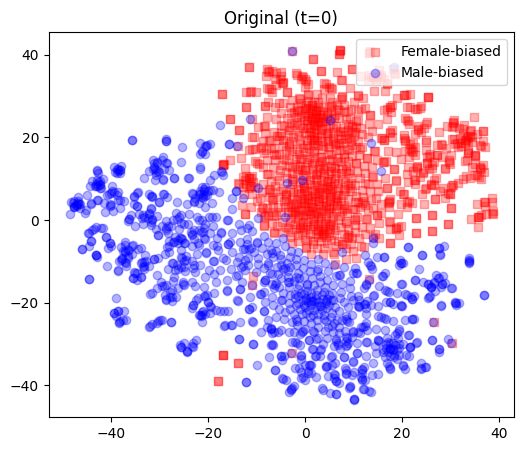

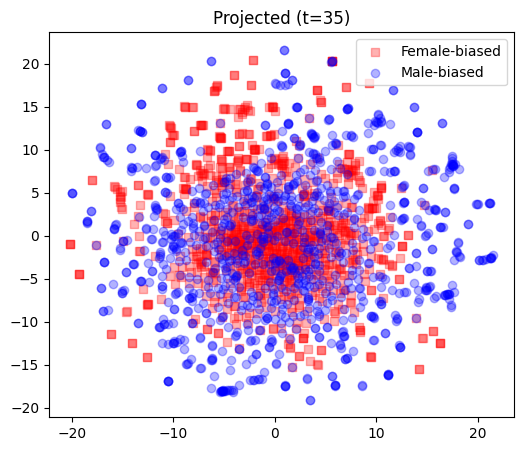

V-measure-before (TSNE space): 0.5674389917292799
V-measure-after (TSNE space): 0.0008322991078064752
V-measure-before (original space): 1.0
V-measure-after (original space): 0.0002113734345872148
Rank before: 300; Rank after: 212


In [15]:
# English

# remove neutral class, keep only male and female biased

X_dev = X_dev[Y_dev != -1]
X_train = X_train[Y_train != -1]
X_test = X_test[Y_test != -1]


Y_dev = Y_dev[Y_dev != -1]
Y_train = Y_train[Y_train != -1]
Y_test = Y_test[Y_test != -1]


M =  2000
ind2label =  {1: "Male-biased", 0: "Female-biased"}
#tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (t=0)", ind2label =ind2label )
tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (t=0)", ind2label =ind2label )


X_dev_cleaned = (P.dot(X_dev.T)).T 
X_test_cleaned = (P.dot(X_test.T)).T 
X_trained_cleaned = (P.dot(X_train.T)).T 
all_significantly_biased_cleaned = P.dot(all_significantly_biased_vecs.T).T

#tsne_after = tsne_by_gender(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t = {})".format(n))
tsne_after = tsne(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t={})".format(n), ind2label =ind2label )

#tsne_projection = tsne_by_gender(all_biased_cleaned, all_significantly_biased_labels,title = "after (all)", words = all_significantly_biased_words)

print("V-measure-before (TSNE space): {}".format(compute_v_measure(tsne_before, all_significantly_biased_labels[:M])))
print("V-measure-after (TSNE space): {}".format(compute_v_measure(tsne_after, all_significantly_biased_labels[:M])))

#print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
#print("V-measure-after (original space): {}".format(compute_v_measure(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-after (original space): {}".format(compute_v_measure(X_test_cleaned[:M], Y_test[:M]), k = 2))

rank_before = np.linalg.matrix_rank(X_train)
rank_after = np.linalg.matrix_rank(X_trained_cleaned)
print("Rank before: {}; Rank after: {}".format(rank_before, rank_after))

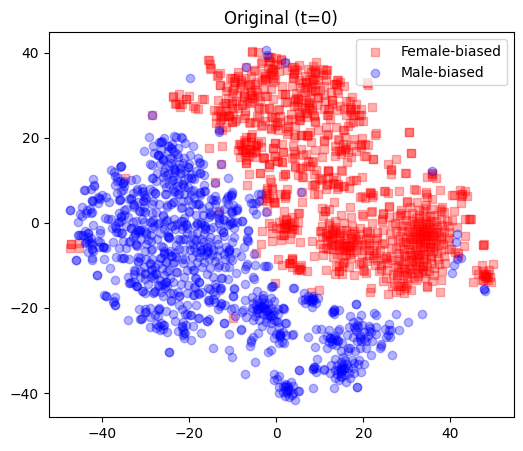

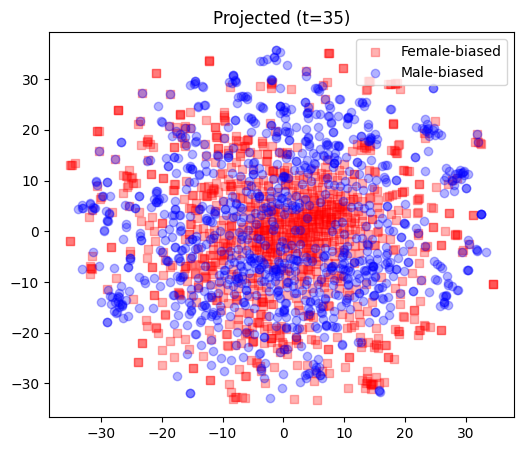

V-measure-before (TSNE space): 0.06027381298890618
V-measure-after (TSNE space): 0.00514988577574879
V-measure-before (original space): 1.0
V-measure-after (original space): 0.000788209089963035
Rank before: 300; Rank after: 198


In [11]:
# Spanish with inlp    

# remove neutral class, keep only male and female biased

X_dev = X_dev[Y_dev != -1]
X_train = X_train[Y_train != -1]
X_test = X_test[Y_test != -1]


Y_dev = Y_dev[Y_dev != -1]
Y_train = Y_train[Y_train != -1]
Y_test = Y_test[Y_test != -1]


M =  2000
ind2label =  {1: "Male-biased", 0: "Female-biased"}
#tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (t=0)", ind2label =ind2label )
tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (t=0)", ind2label =ind2label )


X_dev_cleaned = (P.dot(X_dev.T)).T 
X_test_cleaned = (P.dot(X_test.T)).T 
X_trained_cleaned = (P.dot(X_train.T)).T 
all_significantly_biased_cleaned = P.dot(all_significantly_biased_vecs.T).T

#tsne_after = tsne_by_gender(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t = {})".format(n))
tsne_after = tsne(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t={})".format(n), ind2label =ind2label )

#tsne_projection = tsne_by_gender(all_biased_cleaned, all_significantly_biased_labels,title = "after (all)", words = all_significantly_biased_words)

print("V-measure-before (TSNE space): {}".format(compute_v_measure(tsne_before, all_significantly_biased_labels[:M])))
print("V-measure-after (TSNE space): {}".format(compute_v_measure(tsne_after, all_significantly_biased_labels[:M])))

#print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
#print("V-measure-after (original space): {}".format(compute_v_measure(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-after (original space): {}".format(compute_v_measure(X_test_cleaned[:M], Y_test[:M]), k = 2))

rank_before = np.linalg.matrix_rank(X_train)
rank_after = np.linalg.matrix_rank(X_trained_cleaned)
print("Rank before: {}; Rank after: {}".format(rank_before, rank_after))

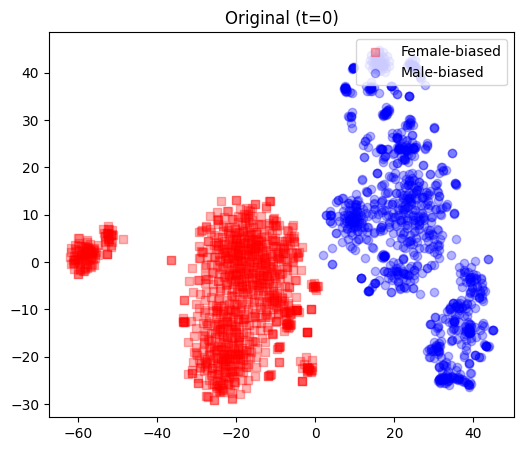

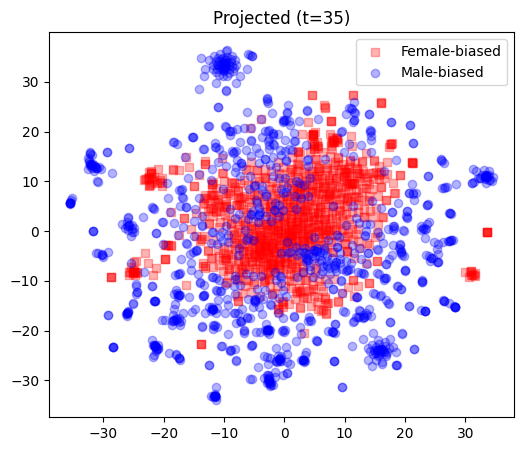

V-measure-before (TSNE space): 1.0
V-measure-after (TSNE space): 0.02120894135735871
V-measure-before (original space): 0.2380795207673479
V-measure-after (original space): 0.007890803536068244
Rank before: 300; Rank after: 195


In [28]:
# French    

# remove neutral class, keep only male and female biased

X_dev = X_dev[Y_dev != -1]
X_train = X_train[Y_train != -1]
X_test = X_test[Y_test != -1]


Y_dev = Y_dev[Y_dev != -1]
Y_train = Y_train[Y_train != -1]
Y_test = Y_test[Y_test != -1]


M =  2000
ind2label =  {1: "Male-biased", 0: "Female-biased"}
#tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (t=0)", ind2label =ind2label )
tsne_before = tsne(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M], title = "Original (t=0)", ind2label =ind2label )


X_dev_cleaned = (P.dot(X_dev.T)).T 
X_test_cleaned = (P.dot(X_test.T)).T 
X_trained_cleaned = (P.dot(X_train.T)).T 
all_significantly_biased_cleaned = P.dot(all_significantly_biased_vecs.T).T

#tsne_after = tsne_by_gender(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t = {})".format(n))
tsne_after = tsne(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M], title = "Projected (t={})".format(n), ind2label =ind2label )

#tsne_projection = tsne_by_gender(all_biased_cleaned, all_significantly_biased_labels,title = "after (all)", words = all_significantly_biased_words)

print("V-measure-before (TSNE space): {}".format(compute_v_measure(tsne_before, all_significantly_biased_labels[:M])))
print("V-measure-after (TSNE space): {}".format(compute_v_measure(tsne_after, all_significantly_biased_labels[:M])))

#print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
#print("V-measure-after (original space): {}".format(compute_v_measure(all_significantly_biased_cleaned[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-before (original space): {}".format(compute_v_measure(all_significantly_biased_vecs[:M], all_significantly_biased_labels[:M]), k = 2))
print("V-measure-after (original space): {}".format(compute_v_measure(X_test_cleaned[:M], Y_test[:M]), k = 2))

rank_before = np.linalg.matrix_rank(X_train)
rank_after = np.linalg.matrix_rank(X_trained_cleaned)
print("Rank before: {}; Rank after: {}".format(rank_before, rank_after))

### Save the embeddings

#### Spanish

In [13]:
new_vectors = (P.dot(model_esp.vectors.T)).T
ES_inlp_debiased_model = KeyedVectors(vector_size = model_esp.vector_size)

ES_inlp_debiased_model.add_vectors( keys = model_esp.index_to_key
                                       , weights = new_vectors )

In [14]:
ES_inlp_debiased_model.save('../data/embeddings/keyedvectors/ES_inlp_debiased_model.kv')

#### French

In [29]:
new_vectors = (P.dot(FR_model.vectors.T)).T
FR_inlp_debiased_model = KeyedVectors(vector_size = FR_model.vector_size)

FR_inlp_debiased_model.add_vectors( keys = FR_model.index_to_key
                                       , weights = new_vectors )

In [30]:
FR_inlp_debiased_model.save('../data/embeddings/keyedvectors/FR_inlp_debiased_model.kv')